In [38]:
BATCH_SIZE = 32
SEED = 10
EPOCHES = 100 # We'll use earlystopping technique

TRAIN_DIRECTORY = "/Users/onur/PycharmProjects/newEnv/intelDataSet/seg_train/seg_train/"
VALIDATION_DIRECTORY = "/Users/onur/PycharmProjects/newEnv/intelDataSet/seg_test/seg_test/"
PRED_DIRECTORY = "/Users/onur/PycharmProjects/newEnv/intelDataSet/seg_pred/seg_pred/"

In [39]:
import matplotlib.pyplot as plt
import os
%matplotlib inline

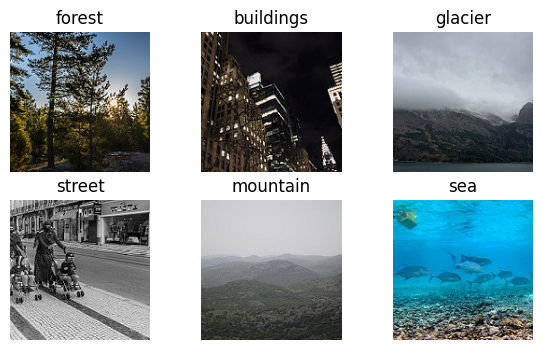

In [40]:
plt.figure(figsize=(7,4))

folderList = os.listdir(TRAIN_DIRECTORY)
folderList.remove(".DS_Store") #We removed .DS_Store from List

for i, folder in enumerate(folderList):
    ax = plt.subplot(2,3,i+1)
    img = plt.imread(TRAIN_DIRECTORY+folder+"/"+os.listdir(TRAIN_DIRECTORY+folder)[0])
    plt.imshow(img)
    plt.title(folder)
    plt.axis("off")

In [41]:
import glob
from collections import Counter

#find the shape of the images

size = []

for folder in os.listdir(TRAIN_DIRECTORY):
    files = glob.glob(pathname= str(TRAIN_DIRECTORY + folder + "/*.jpg")) #Taking all .jpg files
    
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)


In [42]:
Counter(size) # Viewing the size of datas (Mostly 150x150x3)

Counter({(150, 150, 3): 13986,
         (115, 150, 3): 1,
         (108, 150, 3): 2,
         (136, 150, 3): 2,
         (135, 150, 3): 3,
         (133, 150, 3): 1,
         (113, 150, 3): 7,
         (124, 150, 3): 1,
         (111, 150, 3): 3,
         (134, 150, 3): 2,
         (142, 150, 3): 2,
         (149, 150, 3): 1,
         (76, 150, 3): 1,
         (123, 150, 3): 2,
         (105, 150, 3): 1,
         (102, 150, 3): 1,
         (143, 150, 3): 2,
         (146, 150, 3): 2,
         (120, 150, 3): 1,
         (110, 150, 3): 1,
         (97, 150, 3): 1,
         (119, 150, 3): 1,
         (147, 150, 3): 1,
         (103, 150, 3): 1,
         (131, 150, 3): 1,
         (144, 150, 3): 2,
         (100, 150, 3): 1,
         (81, 150, 3): 1,
         (141, 150, 3): 1,
         (145, 150, 3): 1,
         (140, 150, 3): 1})

In [43]:
# We'll count number of pictures in each class/category

categories = [] # Picture Categories
freq = [] # Picture count for each category

for folder in os.listdir(TRAIN_DIRECTORY):
    if folder == ".DS_Store": # We skipped .DS_Store file oherwise this code we'll raise an error.
        continue
    categories.append(folder)
    freq.append(len(os.listdir(TRAIN_DIRECTORY + folder)))

In [44]:
categories

['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']

In [45]:
freq

[2271, 2191, 2404, 2382, 2512, 2274]

Text(0.5, 1.0, 'Number of pictures for each Category')

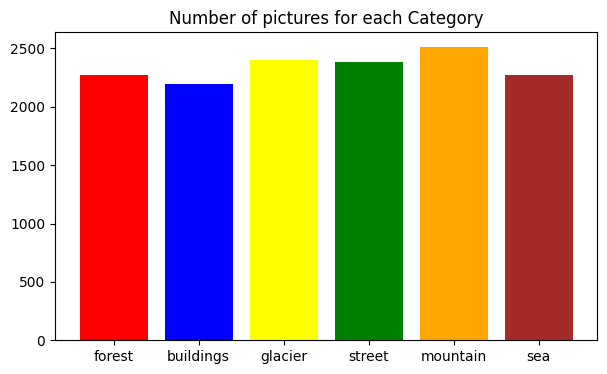

In [46]:
plt.figure(figsize=(7,4))

plt.bar(categories,freq,color=["red","blue","yellow","green","orange","brown"]) # Creating simple bar graph
plt.title("Number of pictures for each Category")

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [48]:
#train set
train_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                         horizontal_flip = True,
                                         rotation_range = 20,
                                         zoom_range = 0.2,
                                         width_shift_range = 0.2,
                                         height_shift_range = 0.2,
                                         shear_range = 0.2)

train_generator = train_data_gen.flow_from_directory(TRAIN_DIRECTORY,
                                                    target_size = (150, 150),
                                                    color_mode = "rgb",
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = "categorical",
                                                    shuffle = True,
                                                    seed = SEED)

#Validation set

val_data_gen = ImageDataGenerator(preprocessing_function= preprocess_input)
validation_generator = val_data_gen.flow_from_directory(VALIDATION_DIRECTORY,
                                                target_size = (150, 150),
                                                color_mode = "rgb",
                                                batch_size = BATCH_SIZE,
                                                class_mode = "categorical",
                                                shuffle = False,
                                                seed = SEED)

#Continuously Check Data if CFD is 1
#else Stop checking data and return current model after comparing with bestmodel.hdf5



Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [49]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [50]:
validation_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [51]:
import numpy as np # We'll display augmented train images

labels = [k for k,v in train_generator.class_indices.items()]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]

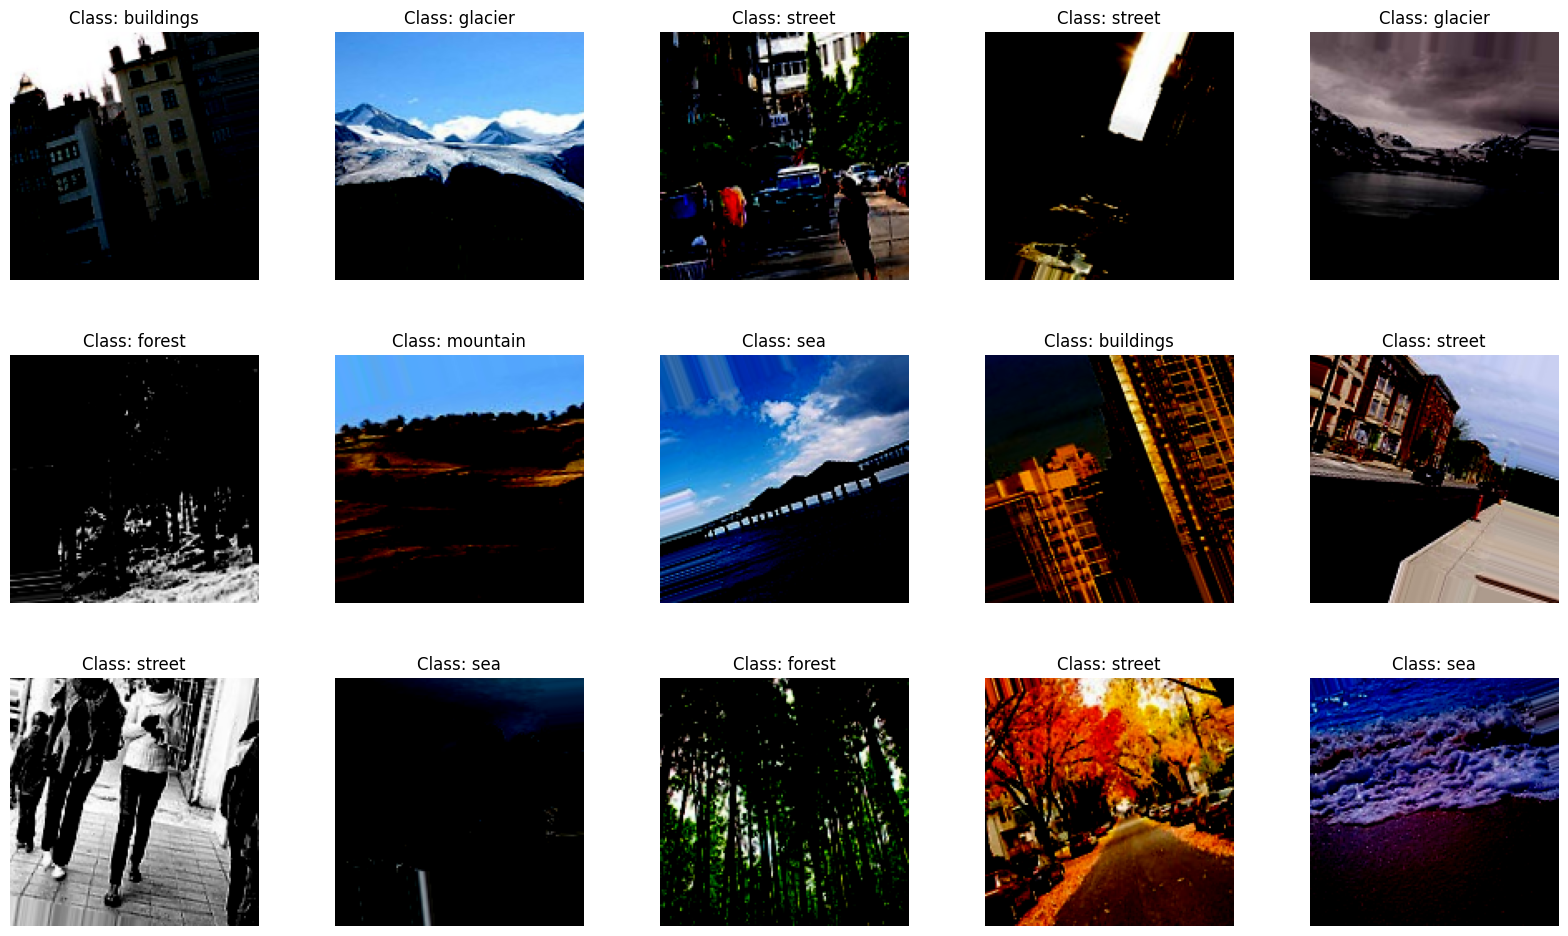

In [52]:
plt.figure(figsize=(20, 20))

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[np.argmax(titles[i],axis=0)]}")
    plt.axis("off")

In [53]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dropout

early_stopping_monitor = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                          patience=3,)

best_model = ModelCheckpoint("bestmodel.hdf5", monitor="val_accuracy", save_best_only=True)

# Train set
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAIN_DIRECTORY,
                                                           labels="inferred",
                                                           label_mode="categorical",
                                                           class_names=None,
                                                           color_mode="rgb",
                                                           batch_size=BATCH_SIZE,
                                                           image_size=(150, 150))
# Validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIRECTORY,
                                                                labels="inferred",
                                                                label_mode="categorical",
                                                                class_names=None,
                                                                color_mode="rgb",
                                                                batch_size=BATCH_SIZE,
                                                                image_size=(150,150))


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [60]:
#Designing the Model
adam = Adam(learning_rate = 0.1)
model = keras.Sequential()

model.add(keras.layers.Conv2D(64,(3,3), activation = "relu", input_shape= (150,150,3)))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(32,(3,3), activation = "relu"))
model.add(keras.layers.MaxPooling2D(3,3))
model.add(keras.layers.Conv2D(32,(3,3), activation = "relu"))
model.add(keras.layers.MaxPooling2D(3,3))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(192,activation="relu",kernel_initializer="normal"))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(keras.layers.Dense(128, activation="relu", kernel_initializer="normal"))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(keras.layers.Dense(64, activation="relu", kernel_initializer="normal"))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(keras.layers.Dense(6,activation="softmax", kernel_initializer="normal"))

model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])

# output_channels * (input_channels * window_size(LayerShape) + 1) == number_parameters
# 64 x (3 x (3 x 3) + 1) = 1792     (3 x 3) --> Because ConvLayer is (3,3)

In [61]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 74, 74, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 7, 7, 32)        

In [63]:
history = model.fit(train_dataset, epochs=10, validation_data = validation_dataset)

Epoch 1/10
439/439 [==============================] - 56s 126ms/step - loss: 0.5948 - accuracy: 0.7976 - val_loss: 0.8631 - val_accuracy: 0.7047
Epoch 2/10
439/439 [==============================] - 56s 128ms/step - loss: 0.5838 - accuracy: 0.7939 - val_loss: 0.6749 - val_accuracy: 0.7540
Epoch 3/10
439/439 [==============================] - 56s 126ms/step - loss: 0.5785 - accuracy: 0.8026 - val_loss: 0.5981 - val_accuracy: 0.7890
Epoch 4/10
439/439 [==============================] - 56s 127ms/step - loss: 0.5778 - accuracy: 0.8030 - val_loss: 0.5300 - val_accuracy: 0.8207
Epoch 5/10
439/439 [==============================] - 56s 127ms/step - loss: 0.5678 - accuracy: 0.8042 - val_loss: 0.5427 - val_accuracy: 0.8097
Epoch 6/10
439/439 [==============================] - 56s 127ms/step - loss: 0.5732 - accuracy: 0.8023 - val_loss: 0.7655 - val_accuracy: 0.7313
Epoch 7/10
439/439 [==============================] - 56s 126ms/step - loss: 0.5732 - accuracy: 0.8033 - val_loss: 0.7356 - val_ac

In [65]:
loss , acc = model.evaluate(train_dataset)
print("Accuracy : ",acc)
print("loss : " , loss)

439/439 [==============================] - 15s 33ms/step - loss: 0.4764 - accuracy: 0.8398
Accuracy :  0.8398175835609436
loss :  0.47637224197387695
